## Xgboost analysis

In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'pcanewss.xlsx' 
data = pd.read_excel(file_path)
print(data.head())

X = data[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']]
y = data['logreturn']
y.head()

   logreturn        f1        f2        f3        f4        f5        f6  \
0   0.014110  4.798603  4.291953  0.096115 -0.915052  1.665008  0.334631   
1   0.004389  4.777986  4.650318  0.538249 -0.841286  1.652642  0.600573   
2  -0.009372  4.764654  4.265499  0.066010 -1.018443  1.649977  0.753251   
3   0.005736  4.723674  4.242907  0.049920 -1.107658  1.669910  0.458335   
4   0.011969  4.720298  4.265986  0.088056 -0.870258  1.729706  0.997562   

         f7  
0 -0.286816  
1  0.067374  
2 -0.054899  
3 -0.511413  
4  0.209364  


0    0.014110
1    0.004389
2   -0.009372
3    0.005736
4    0.011969
Name: logreturn, dtype: float64

### Original Xgboost Model

In [4]:
#Time-series partitioned dataset (80% as training set, 20% as test set)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#split the validation set from the training set (last 10% as validation set for early-stopping)
val_size = int(len(X_train) * 0.1)
X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

#define model
xgb = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'n_estimators': [100, 500, 1000] 
}

#Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=tscv,                            
    verbose=1,                        
    n_jobs=-1                         
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

best_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10,
    **best_params
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared: {r2}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Best Score (Negative MSE): -7.270658073592595e-05
Mean Squared Error on Test Data: 6.158795585858584e-05
R-squared: -4.172987226880309e-07


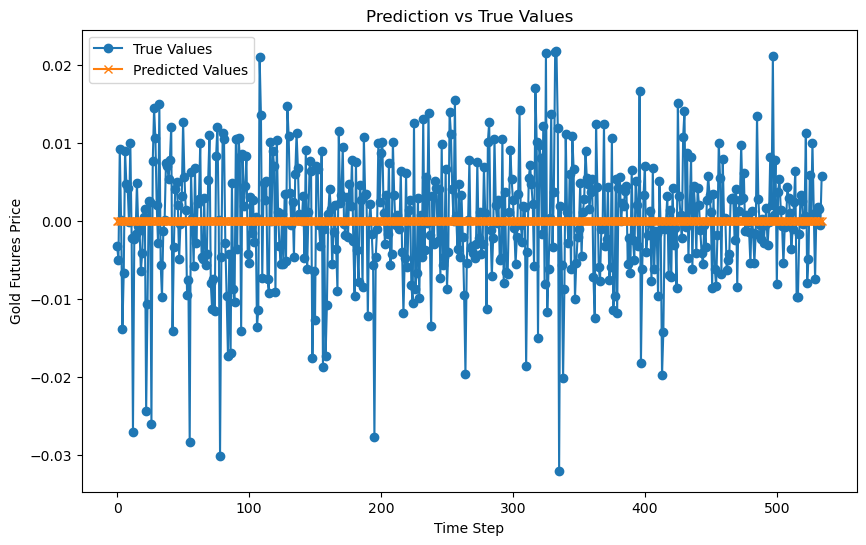

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", marker='o')
plt.plot(y_pred, label="Predicted Values", marker='x')
plt.title("Prediction vs True Values")
plt.xlabel("Time Step")
plt.ylabel("Gold Futures Price")
plt.legend()
plt.show()

Through the negative $R^2$ value and the figure illustrating the distribution of prediction and true values, we can observe that the model's training performance is poor, even worse than simply predicting the mean of the target variable. Therefore, in the subsequent analysis, we will incorporate additional features, such as lag features and moving average features, to better capture the characteristics of the time series.

### Adding Time Window Features

In the new model, I added:

**Lagged features:** includes returns from the past 1 to 3 days, capturing the effect of history on current returns.

**Moving Average Feature:** calculates the average of log returns over the past 3 and 5 days, used to smooth out volatility and identify trends.

**Moving Standard Deviation Feature:** Calculates the standard deviation of returns over the past 3 and 5 days to measure market volatility and risk levels.



In [14]:
from sklearn.preprocessing import StandardScaler
# lag features
for lag in range(1, 4):
    data[f'log_return_lag_{lag}'] = data['logreturn'].shift(lag)

# rolling features without forward looking
data['rolling_mean_3'] = data['logreturn'].rolling(window=3, min_periods=3).mean()
data['rolling_mean_5'] = data['logreturn'].rolling(window=5, min_periods=5).mean()
data['rolling_std_3'] = data['logreturn'].rolling(window=3, min_periods=3).std()
data['rolling_std_5'] = data['logreturn'].rolling(window=5, min_periods=5).std()
data = data.dropna()

X = data[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'log_return_lag_1', 'log_return_lag_2', 'log_return_lag_3', 
          'rolling_mean_3', 'rolling_mean_5', 'rolling_std_3', 'rolling_std_5']]
y = data['logreturn']


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

val_size = int(len(X_train) * 0.1)
X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#define model
xgb = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'n_estimators': [100, 500, 1000] 
}

#Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=tscv,                            
    verbose=1,                        
    n_jobs=-1                         
)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

best_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10,
    **best_params
)

best_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared: {r2}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Best Score (Negative MSE): -6.58455654065039e-06
Mean Squared Error on Test Data: 1.719773238962961e-06
R-squared: 0.9721502833374751


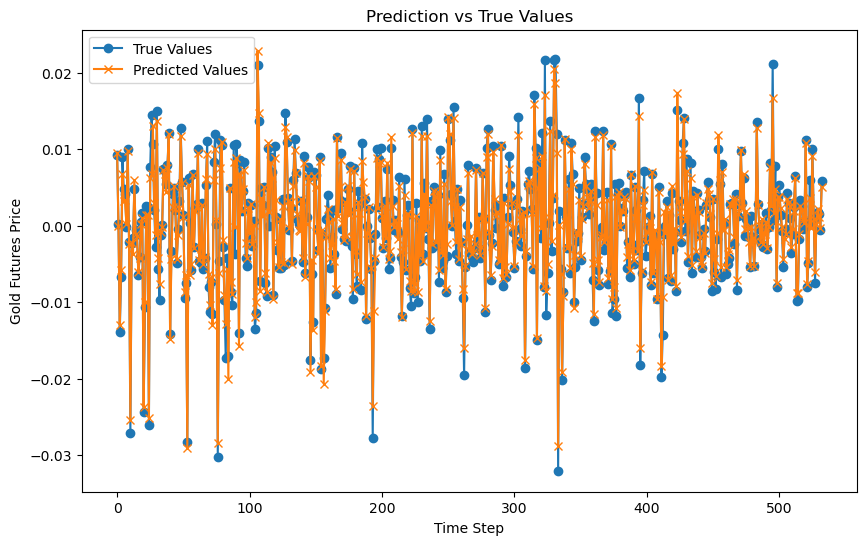

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", marker='o')
plt.plot(y_pred, label="Predicted Values", marker='x')
plt.title("Prediction vs True Values")
plt.xlabel("Time Step")
plt.ylabel("Gold Futures Price")
plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

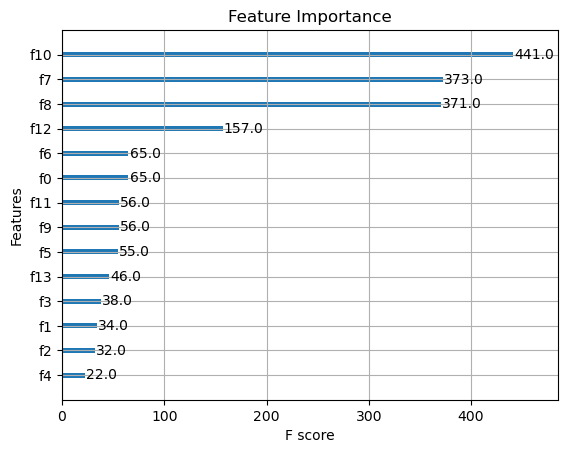

In [18]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', title='Feature Importance')
plt.show()

By graphing the distribution of predicted and true values and the $R^2$ value (0.9763), we can see that the new model fits well. In particular, `log_return_lag_1`, `log_return_lag_2` and `rolling_mean_3` features have the strongest explanatory power to the model. This suggests that historical returns have an important influence on current returns and that short-term trends are effectively captured by the moving average feature. Adding time window features helps the model to identify the overall direction and momentum of the market.